# All Regression Notebook
## Load dữ liệu
Khai báo và load thư viện, sau đó load tập dữ liệu. Do tập dữ liệu không chứa tên cột nên chúng ta cần thêm nó vào bằng cách sử dụng list Python thủ công. 

Chúng ta có `all_train_data` và `all_test_data` đã được nối vào `DataFrame` tương ứng.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

columns_name = ["Popularity", "Check-in", "Activities", "Category"] \
            + ["F_{:d}".format(i) for i in range(1, 26)] \
            + ["CC{:d}".format(i) for i in range(1, 6)] \
            + ["Base time", "Post length", "Post count", "Post promotion", "Span time"] \
            + ["Post_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Base_date_{:d}".format(i) for i in range(1, 8)] \
            + ["Span count"]
all_train_data = [pandas.read_csv("Dataset/Training/Features_Variant_{:d}.csv".format(d), header=None) for d in range(1, 6)]

for data in all_train_data:
    print("Train sets size: {:d}".format(data.size))
# Viết code nối dữ liệu huấn luyện
train_data=pandas.concat(all_train_data,ignore_index=True)
train_data.columns = columns_name

all_test_data = [pandas.read_csv("Dataset/Testing/TestSet/Test_Case_{:d}.csv".format(d), header=None) for d in range(1, 10)]
# Viết code nối dữ liệu kiểm tra
test_data=pandas.concat(all_test_data,ignore_index=True)
test_data.columns = columns_name

train_data["bias"] = 1
test_data["bias"] = 1
print(train_data.columns)


Train sets size: 2211246
Train sets size: 4390848
Train sets size: 6539292
Train sets size: 8662896
Train sets size: 10747620
Index(['Popularity', 'Check-in', 'Activities', 'Category', 'F_1', 'F_2', 'F_3',
       'F_4', 'F_5', 'F_6', 'F_7', 'F_8', 'F_9', 'F_10', 'F_11', 'F_12',
       'F_13', 'F_14', 'F_15', 'F_16', 'F_17', 'F_18', 'F_19', 'F_20', 'F_21',
       'F_22', 'F_23', 'F_24', 'F_25', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5',
       'Base time', 'Post length', 'Post count', 'Post promotion', 'Span time',
       'Post_date_1', 'Post_date_2', 'Post_date_3', 'Post_date_4',
       'Post_date_5', 'Post_date_6', 'Post_date_7', 'Base_date_1',
       'Base_date_2', 'Base_date_3', 'Base_date_4', 'Base_date_5',
       'Base_date_6', 'Base_date_7', 'Span count', 'bias'],
      dtype='object')


## Lựa chọn hạng mục phụ
Cột Category chứa các index bất kỳ của hạng mục dữ liệu liên quan tới bản chất của chính bài đăng. Để đơn giản, chúng ta sẽ sử dụng hạng mục có lượng dữ liệu lớn nhất để thực hiện Hồi quy Tuyến tính.

Tìm và lựa chọn hạng mục có nhiều bản ghi nhất sử dụng pandas. Lưu nó trong biến `largest_category`

In [2]:
# Viết code ở đây:
group_category=train_data.groupby(['Category']).size()
largest_category=group_category[group_category==(max(group_category))].index[0]



In [3]:
# Phân hạng các mô hình
train_data = train_data.loc[train_data['Category'] == largest_category].drop('Category', axis=1)
test_data = test_data.loc[test_data['Category'] == largest_category].drop('Category', axis=1)
label = "Span count"
features = [col for col in train_data.columns if col != label]
train_features = train_data[ features ]
train_labels = train_data[ label ]
test_features = test_data[ features ]
test_labels = test_data[ label ]

## Tương quan cơ bản
Chúng ta sẽ vẽ ma trận tương quan giữa các biến CC. Tương quan rất hữu ích để xem liệu các đặc trưng có kết nối quá chặt chẽ không -  chúng ta không muốn chúng cùng nhau vì chúng sẽ tạo ra nhiễu giả gây overfit mô hình.

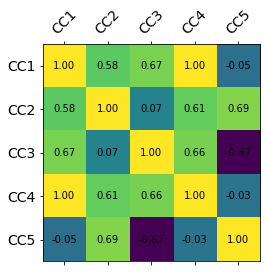

In [4]:
# Viết code ở đây:
corr=train_data[["CC1","CC2","CC3","CC4","CC5"]].corr()
fig, ax = plt.subplots()
im = ax.matshow(corr.values)
for (i, j), z in np.ndenumerate(corr.values):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
plt.xticks(range(train_data[["CC1","CC2","CC3","CC4","CC5"]].shape[1]), train_data[["CC1","CC2","CC3","CC4","CC5"]].columns, fontsize=14, rotation=45)
plt.yticks(range(train_data[["CC1","CC2","CC3","CC4","CC5"]].shape[1]), train_data[["CC1","CC2","CC3","CC4","CC5"]].columns, fontsize=14)
plt.show()


## Xây dựng mô hình Hồi quy

__Nhiệm vụ của chúng ta là dự đoán số lượng bình luận bài đăng sẽ nhận được (cột "Span count")__ <br>
"Span time" thì cần thiết trong khi tất cả các cột khác tùy chọn. <br>
Thử mô hình Hồi quy đa biến đơn giản chỉ có các đặc trưng cơ bản: <br>
["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]. <br>

In ra hệ số MSE từ sklearn hoặc RSS từ khóa học cho cả tập huấn luyện và tập kiểm tra.

In [5]:
# Viết code ở đây:
train_features1=train_features[["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]].values
train_labels1=train_labels.values
test_features1=test_features[["Popularity", "Base time", "Post length", "Post count", "Span time", "bias"]].values
test_labels1=test_labels.values
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model1=LinearRegression().fit(train_features1,train_labels1)
print(mean_squared_error(model1.predict(train_features1),train_labels1))
print(mean_squared_error(model1.predict(test_features1),test_labels1))




1689.5665198601353
5340.589651600898


### Hãy thử cải thiện với nhiều đặc trưng hơn
Không phải mô hình tốt nhất chúng ta có thể sử dụng. Chúng ta có thể thử thêm nhiều đặc trưng liên quan. <br>Nối tất cả các thuộc tính CC vào các đặc trưng và thử lại với cùng số liệu.

In [6]:
# Viết code ở đây:
train_features2=train_features[["Popularity", "Base time", "Post length", "Post count", "Span time", "bias","CC1","CC2","CC3","CC4","CC5"]].values
train_labels2=train_labels.values
test_features2=test_features[["Popularity", "Base time", "Post length", "Post count", "Span time", "bias","CC1","CC2","CC3","CC4","CC5"]].values
test_labels2=test_labels.values
model2=LinearRegression().fit(train_features2,train_labels2)
print(mean_squared_error(model2.predict(train_features2),train_labels2))
print(mean_squared_error(model2.predict(test_features2),test_labels2))


1535.0187590146174
3878.5320956240835


Bài học rút ra: Tối ưu hóa sớm hiếm khi hữu ích. 

## Giải quyết overfit
### Áp dụng cách giải cho overfit

Sự khác biệt về hệ số huấn luyện và kiểm tra chỉ ra mô hình có thể overfitting. Hãy thử sửa chữa. Mở rộng hồi quy [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) (cv = 10) với alpha dọc theo logspace giữa 0 và 10, ghi nhận giá trị có chất lượng tốt nhất thành biến `best_alpha`, và *có thể tùy chọn vẽ một đồ thị cho độ lớn của các hệ số*.

c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.55904e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.60312e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.51454e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.65105e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=Tr

1000000.0
1535.1869678391133
3914.1018540245636


c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.42216e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
c:\users\buu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.42216e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


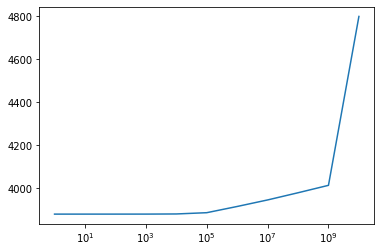

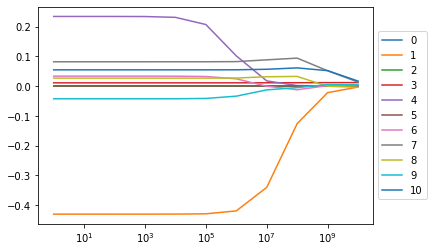

In [36]:
# Viết code ở đây:
alphas=np.logspace(0,10,11)
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
model3=RidgeCV(alphas=alphas,cv=10).fit(train_features2,train_labels2)
best_alpha=model3.alpha_
print(best_alpha)
print(mean_squared_error(model3.predict(train_features2),train_labels2))
print(mean_squared_error(model3.predict(test_features2),test_labels2))
mse=[]
df = pandas.DataFrame()
for i in range(len(alphas)):
    name='model'+str(i)
    model=Ridge(alpha=alphas[i]).fit(train_features2,train_labels2)
    mse.append(mean_squared_error(model.predict(test_features2),test_labels2))
    df[name]=model.coef_

fig,ax =plt.subplots()
ax.set_xscale('log')
ax.plot(alphas,mse)

fig,ax=plt.subplots()
ax.set_xscale('log')
#ax.set_yscale('log')
for i in range(len(alphas)):
    ax.plot(alphas,df.iloc[i],label=i)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### Thử Hồi quy RidgeCV trên mọi cột
Nó đã hoạt động, nhưng chúng ta cần tự hỏi liệu có tiếp tục sử dụng tập đặc trưng không hoàn thiện thay vì một tập hợp tối ưu nữa không. Mở rộng các đặc trưng cho tất cả các cột trừ nhãn được chỉ định. Hãy chạy và xem điều gì sẽ xảy ra.

In [41]:
# Viết code ở đây:
from sklearn.preprocessing import StandardScaler
label ="Span count"
features = [col for col in train_data.columns if col != label]

train_features = train_data[features]
train_labels = train_data[label]
test_features = test_data[features]
test_labels = test_data[label]

scaler=StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

multi_model = RidgeCV(alphas=alphas,cv=10)
multi_model.fit(train_features, train_labels)
test_predictions = multi_model.predict(test_features)

test_mse_score = mean_squared_error(test_predictions, test_labels)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))

MSE on training: 1512.2733; MSE on test: 3928.3796


## Lựa chọn đặc trưng
### Áp dụng LASSO
Chúng ta có thể cắt tỉa các đặc trưng sử dụng những gì đã học. Lần này sẽ ghi lại các đặc trưng đã chọn của [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) (cv = 10) sử dụng biến `lasso_selected_features`, và <i>có thể tùy chọn vẽ một đồ thị giữa số lượng đặc trưng đã loại và các giá trị alpha</i>.

[ 0.         -0.          0.         -0.          0.          0.
  0.          0.55654067 -0.          0.          0.65372882  2.36650699
  0.         -0.          0.          0.          0.79585017  0.
 -0.          0.          0.          0.          0.         -0.
  0.          0.         -0.          0.         -0.          8.91023334
 -0.         -0.          4.74558256 -8.53459785 -0.          6.99421984
  0.          0.         -0.         -0.          0.         -0.
 -0.          0.          0.          0.         -0.          0.
  0.         -0.         -0.          0.          0.        ]
['F_5', 'F_8', 'F_9', 'F_14', 'CC2', 'CC5', 'Base time', 'Post count']


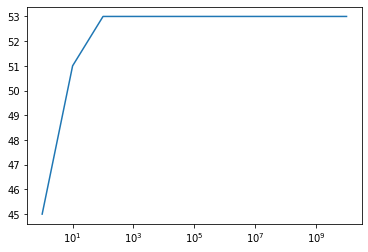

In [47]:
# Viết code ở đây:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
model4=LassoCV(alphas=alphas,cv=5).fit(train_features,train_labels)
print(model4.coef_)
lasso_selected_features=list(np.array(features)[model4.coef_!=0])

print(lasso_selected_features)
features_null=[]
for i in range(len(alphas)):
    model=Lasso(alpha=alphas[i]).fit(train_features,train_labels)
    features_null.append(len(np.array(features)[model.coef_==0]))

fig,ax =plt.subplots()
ax.set_xscale('log')
ax.plot(alphas,features_null) 


### Xây dựng mô hình chặt chẽ hơn với các đặc trưng đã chọn
Khi thực hiện lựa chọn đặc trưng, chúng ta có thể sẽ phải thêm lại độ chệch vào list các đặc trưng. Hãy sử dụng các đặc trưng đã chọn để xây dựng mô hình và tính toán chất lượng dựa trên các chỉ số.

In [49]:
if("bias" not in lasso_selected_features):
    lasso_selected_features.append('bias')


In [56]:
# Viết code ở đây:
train_features = train_data[lasso_selected_features]
train_labels = train_data[label]
test_features = test_data[lasso_selected_features]
test_labels = test_data[label]

scaler1=StandardScaler()
train_features =scaler1.fit_transform(train_features)
test_features = scaler1.transform(test_features)

model5=LassoCV(alphas=alphas,cv=5).fit(train_features,train_labels)

print(mean_squared_error(model5.predict(test_features),test_labels))

4072.3628017916612


## Kết hợp mọi thứ trên một mô hình
LASSO đã thực hiện rất tốt, thu nhỏ các đặc trưng nhiễu và không cần thiết, tăng tốc độ tính toán. Bây giờ hãy kết hợp cả 2 kỹ thuật trước đó vào cùng một mô hình.

In [57]:
# Viết code ở đây:
multi_model = RidgeCV(alphas=alphas,cv=10)
multi_model.fit(train_features, train_labels)
test_predictions = multi_model.predict(test_features)

test_mse_score = mean_squared_error(test_predictions, test_labels)
train_mse_score = mean_squared_error(train_labels, multi_model.predict(train_features))
print("MSE on training: {:.4f}; MSE on test: {:.4f}".format(train_mse_score, test_mse_score))



MSE on training: 1519.5080; MSE on test: 4109.2505


### Phân phối sai số bình phương
Chúng ta hãy đưa ra kết luận; lưu ý thêm, hãy quan sát cách các sai số bình phương được phân phối.

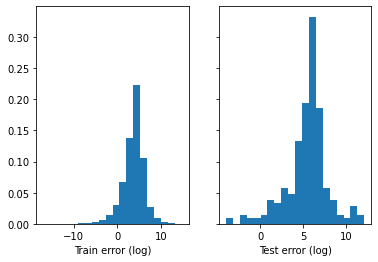

In [58]:
train_square_errors = np.log( (train_labels - multi_model.predict(train_features)) ** 2 )
test_square_errors = np.log( (test_labels - test_predictions) ** 2 )
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharey=True)
train_ax.hist(train_square_errors, bins=20, density=True)
train_ax.set_xlabel("Train error (log)")
test_ax.set_xlabel("Test error (log)")
test_ax.hist(test_square_errors, bins=20, density=True)
plt.show()